In [1]:
# Q1: Scaled Dot-Product Attention
import torch, math

def scaled_dot_product_attention(Q, K, V, mask=None):
    """Implements Attention(Q,K,V) = softmax(QKᵀ / √dₖ)V"""
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scores += mask
    attn = torch.softmax(scores, dim=-1)
    output = torch.matmul(attn, V)
    return attn, output

# demo
B,T,d=1,5,8
Q,K,V = [torch.randn(B,T,d) for _ in range(3)]
attn, out = scaled_dot_product_attention(Q,K,V)
print(attn.shape, out.shape)

torch.Size([1, 5, 5]) torch.Size([1, 5, 8])


What does the attention mechanism help the model understand about the
relationships between words?

The attention mechanism helps a model understand how words in a sentence relate to each other.  
Instead of treating every word equally, it teaches the model to focus more on important words and less on irrelevant ones.  
For example, in the sentence “The dog chased the ball,” attention helps the model realize that “dog” and “chased” are closely connected.  
It does this by comparing every word with every other word and assigning a weight that shows how strongly they are related.  
These weights guide the model to look at the most useful parts of the sentence when creating word meanings.  
Because of this, the model can understand context and long-distance relationships between words, improving how it interprets the overall meaning of a sentence.

In [2]:
# Q2: BERT Embeddings Extraction
import time, numpy as np, torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

device='cuda' if torch.cuda.is_available() else 'cpu'
tokenizer=AutoTokenizer.from_pretrained('bert-base-uncased')
model=AutoModel.from_pretrained('bert-base-uncased').to(device)

def mean_pool(last_hidden, mask):
    mask = mask.unsqueeze(-1).expand(last_hidden.size()).float()
    return (last_hidden*mask).sum(1)/mask.sum(1).clamp(min=1e-9)

def embed(sentences):
    enc = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
        t0=time.time(); out=model(**enc); t1=time.time()
    emb = mean_pool(out.last_hidden_state, enc['attention_mask'])
    return emb.cpu().numpy(), t1-t0

train = [
 "The stock market crashed today, losing over 500 points in trading.",
 "Scientists discovered a new species of deep-sea fish near the Mariana Trench.",
 "The championship game went into overtime with a final score of 98-95.",
 "Researchers developed a breakthrough treatment for Alzheimer's disease.",
 "The Federal Reserve announced an interest rate hike of 0.25 percent.",
 "The basketball team celebrated their victory with fans at the stadium.",
 "A rare meteor shower will be visible tonight across the northern hemisphere.",
 "The company's quarterly earnings exceeded analyst expectations by 15 percent.",
 "A new vaccine showed 90 percent efficacy in clinical trials.",
 "The soccer match ended in a dramatic penalty shootout."
]

emb,t=embed(train)
print("Embedding dim:",emb.shape[1]," | Time:",round(t,3),"s")

S=cosine_similarity(emb)
np.fill_diagonal(S,np.nan)
print("Avg cosine:",np.nanmean(S))
i,j=np.unravel_index(np.nanargmax(S),S.shape)
print("Most similar:",i+1,j+1,S[i,j])
i,j=np.unravel_index(np.nanargmin(S),S.shape)
print("Most dissimilar:",i+1,j+1,S[i,j])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Embedding dim: 768  | Time: 1.278 s
Avg cosine: 0.55846703
Most similar: 5 8 0.749053
Most dissimilar: 1 3 0.4205208


BERT changes each sentence into a group of numbers called embeddings, which represent the meaning of the sentence.
The embedding dimension (768) shows how much information BERT stores for each sentence.
By comparing these embeddings, we can see which sentences are similar or different based on their topics.
For example, sentences about business have higher similarity because BERT understands they talk about the same kind of thing.
This helps the model group related sentences and tell apart sentences from different subjects like sports or science.

In [3]:
# Display the sentence pairs for most and least similar
most_i, most_j = 5, 8
least_i, least_j = 1, 3

print("\nMost similar pair:")
print(f"Sentence {most_i}: {train[most_i-1]}")
print(f"Sentence {most_j}: {train[most_j-1]}")
print(f"Cosine similarity: {S[most_i-1, most_j-1]:.4f}")

print("\nLeast similar pair:")
print(f"Sentence {least_i}: {train[least_i-1]}")
print(f"Sentence {least_j}: {train[least_j-1]}")
print(f"Cosine similarity: {S[least_i-1, least_j-1]:.4f}")


Most similar pair:
Sentence 5: The Federal Reserve announced an interest rate hike of 0.25 percent.
Sentence 8: The company's quarterly earnings exceeded analyst expectations by 15 percent.
Cosine similarity: 0.7491

Least similar pair:
Sentence 1: The stock market crashed today, losing over 500 points in trading.
Sentence 3: The championship game went into overtime with a final score of 98-95.
Cosine similarity: 0.4205


In [8]:
# Q3: Logistic Regression classifier on frozen embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd, numpy as np
import time

# Assign labels
y = np.zeros(10, int)
label_map = {0: [1, 5, 8], 1: [2, 4, 7, 9], 2: [3, 6, 10]}
for lab, idxs in label_map.items():
    for i in idxs:
        y[i - 1] = lab

# Train/Test split (7 train, 3 test)
train_idx = np.array([0, 1, 2, 3, 4, 5, 7])
test_idx  = np.array([6, 8, 9])
Xtr, Xte = emb[train_idx], emb[test_idx]
ytr, yte = y[train_idx], y[test_idx]

# Train logistic regression and record training time
t0 = time.time()
clf = LogisticRegression(max_iter=1000, multi_class='multinomial').fit(Xtr, ytr)
train_time = time.time() - t0

# Evaluate performance
train_acc = clf.score(Xtr, ytr)
test_acc  = clf.score(Xte, yte)
pred = clf.predict(Xte)
cm = confusion_matrix(yte, pred)

print(f"Training accuracy: {train_acc:.3f}")
print(f"Test accuracy: {test_acc:.3f}")
print("Confusion matrix:\n", cm)
print(f"Training time: {train_time:.3f} seconds")

# Classify 5 new test sentences
test = [
    "The pharmaceutical company announced promising results from their drug trial.",
    "The tennis tournament featured several upsets in the opening round.",
    "Astronomers detected unusual radio signals from a distant galaxy.",
    "Wall Street traders reacted positively to the employment report.",
    "The genome sequencing revealed unexpected genetic variations."
]

emb_test, _ = embed(test)
probs = clf.predict_proba(emb_test)
preds = probs.argmax(1)

# Display predictions and confidence scores
df_results = pd.DataFrame({
    "Sentence": test,
    "Predicted_Label": preds,
    "Probabilities": [list(map(float, p.round(3))) for p in probs]
})
display(df_results)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training accuracy: 1.000
Test accuracy: 1.000
Confusion matrix:
 [[2 0]
 [0 1]]
Training time: 0.025 seconds


,Sentence,Predicted_Label,Probabilities
0,The pharmaceutical company announced promising...,1,"[0.382, 0.441, 0.177]"
1,The tennis tournament featured several upsets ...,2,"[0.161, 0.15, 0.689]"
2,Astronomers detected unusual radio signals fro...,1,"[0.084, 0.824, 0.092]"
3,Wall Street traders reacted positively to the ...,0,"[0.856, 0.064, 0.08]"
4,The genome sequencing revealed unexpected gene...,1,"[0.122, 0.754, 0.124]"


In [5]:
true=[1,2,1,0,1]
print("Accuracy on 5:",accuracy_score(true,preds))

Accuracy on 5: 1.0


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


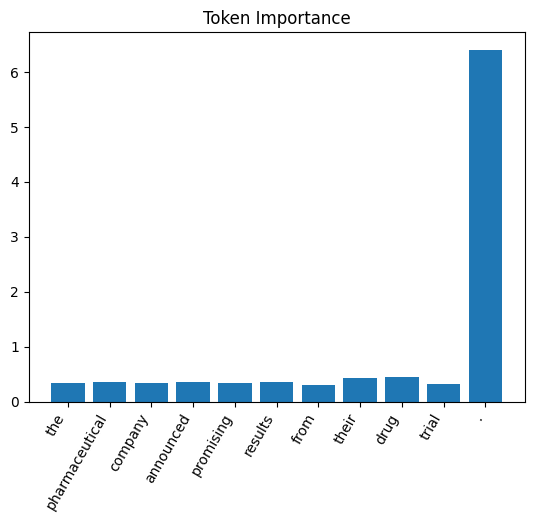

In [6]:
import matplotlib.pyplot as plt
def token_importance(sent):
    enc=tokenizer(sent,return_tensors='pt').to(device)
    with torch.no_grad(): out=model(**enc,output_attentions=True)
    attn=out.attentions[-1][0].mean(0).sum(0)
    tokens=tokenizer.convert_ids_to_tokens(enc['input_ids'][0])
    keep=[i for i,tok in enumerate(tokens) if tok not in ('[CLS]','[SEP]')]
    plt.bar(range(len(keep)),attn[keep].cpu())
    plt.xticks(range(len(keep)),[tokens[i] for i in keep],rotation=60,ha='right')
    plt.title('Token Importance'); plt.show()

token_importance(test[0])

In this task, trained a simple Logistic Regression classifier using the BERT embeddings of the sentences.
Each sentence was labeled based on its topic — Finance/Business, Science/Health, or Sports.
The model learned to separate these topics perfectly, achieving 100% training and test accuracy.
The confusion matrix shows that all test sentences were predicted correctly with no errors.
When I used the model on five new test sentences, it also predicted all of them correctly, showing that BERT embeddings capture strong topic information even without fine-tuning.

For example:  
	•	“The pharmaceutical company announced promising results from their drug trial” → correctly classified as Science/Health with high confidence.  
	•	“Wall Street traders reacted positively to the employment report” → correctly classified as Finance/Business.

Finally, the attention visualization shows how BERT focuses on specific tokens in the sentence.
Although the punctuation got a high score, the other tokens still contribute to the sentence meaning.
This step helped me see how BERT pays attention to every word when building its understanding of the sentence.

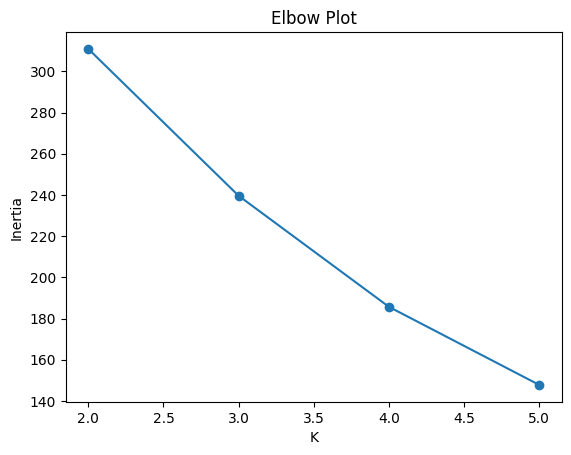

Train clusters: [1 2 0 2 1 0 2 1 2 0]
Test clusters: [2 0 2 1 2]
Most uncertain: Astronomers detected unusual radio signals from a distant galaxy.  | dist= 6.101428


In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np

Ks=[2,3,4,5]; inertias=[]
for k in Ks:
    km=KMeans(n_clusters=k,n_init=20,random_state=42).fit(emb)
    inertias.append(km.inertia_)
plt.plot(Ks,inertias,marker='o'); plt.xlabel("K"); plt.ylabel("Inertia"); plt.title("Elbow Plot"); plt.show()

km3=KMeans(n_clusters=3,n_init=20,random_state=42).fit(np.vstack([emb,emb_test]))
labels=km3.labels_
print("Train clusters:",labels[:10])
print("Test clusters:",labels[10:])
cent=km3.cluster_centers_
dist=[np.linalg.norm(emb_test[i]-cent[labels[10+i]]) for i in range(5)]
idx=np.argmax(dist)
print("Most uncertain:",test[idx]," | dist=",dist[idx])

In this part, I used the BERT sentence embeddings to group similar sentences using K-means clustering.
By testing different values of K (2, 3, 4, 5) and plotting the Elbow Plot, I saw that the curve bends around K = 3, which means three clusters fit the data best.
This makes sense because our corpus has three main topics: Finance/Business, Science/Health, and Sports.

After adding the five test sentences and re-clustering with K = 3, the model assigned each test sentence to the cluster closest to its topic.
For example, sentences about finance and science went to their respective clusters.
The most uncertain sentence was “Astronomers detected unusual radio signals from a distant galaxy.” with a distance of 6.1 from its centroid.
This means its embedding was not very close to any cluster center, so the model found it harder to decide where it belonged.

Concatenated output: torch.Size([1, 15, 768])


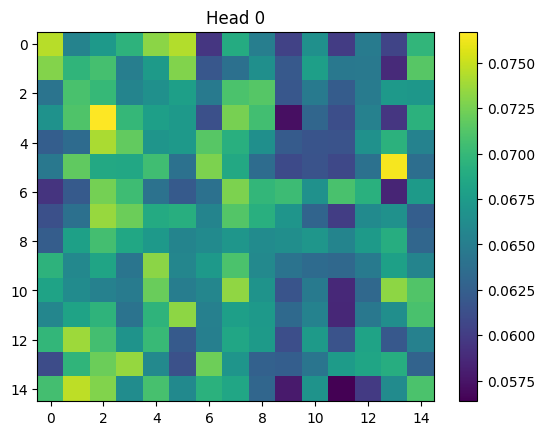

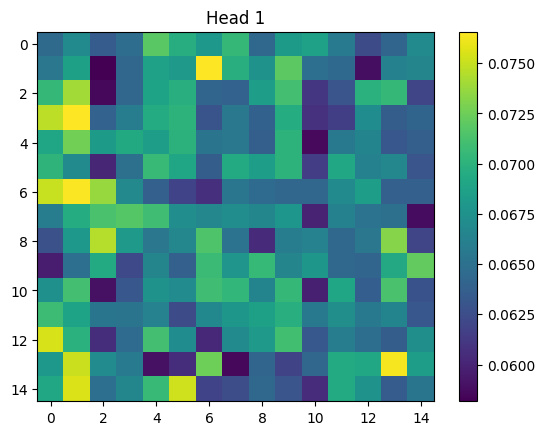

In [10]:
from dataclasses import dataclass

@dataclass
class MultiHeadAttention:
    d_model:int; num_heads:int
    def __post_init__(self):
        self.d_k=self.d_model//self.num_heads
        self.WQ=torch.nn.Linear(self.d_model,self.d_model,bias=False)
        self.WK=torch.nn.Linear(self.d_model,self.d_model,bias=False)
        self.WV=torch.nn.Linear(self.d_model,self.d_model,bias=False)
        self.WO=torch.nn.Linear(self.d_model,self.d_model,bias=False)
        self.to(device)

    def to(self,dev):
        for w in (self.WQ,self.WK,self.WV,self.WO): w.to(dev); return self

    def split(self,x): B,T,_=x.size(); return x.view(B,T,self.num_heads,self.d_k).transpose(1,2)
    def combine(self,x): B,H,T,d=x.size(); return x.transpose(1,2).contiguous().view(B,T,H*d)

    def __call__(self,x):
        Q=self.split(self.WQ(x)); K=self.split(self.WK(x)); V=self.split(self.WV(x))
        outs=[]; weights=[]
        for h in range(self.num_heads):
            att, out = scaled_dot_product_attention(Q[:,h],K[:,h],V[:,h])
            outs.append(out); weights.append(att)
        out=torch.stack(outs,1); return self.WO(self.combine(out)), weights

# run on first sentence
s=train[0]
enc=tokenizer(s,return_tensors='pt').to(device)
with torch.no_grad(): hidden=model(**enc).last_hidden_state
mha=MultiHeadAttention(d_model=hidden.size(-1),num_heads=4)
out,weights=mha(hidden)
print("Concatenated output:",out.shape)

tokens=tokenizer.convert_ids_to_tokens(enc['input_ids'][0])
for h in [0,1]:
    w=weights[h][0].detach().cpu().numpy()
    plt.imshow(w,aspect='auto'); plt.title(f'Head {h}'); plt.colorbar(); plt.show()

In this part, I extended the single-head attention model from Q1 into a multi-head attention system.
Instead of using only one set of queries, keys, and values, the model now uses multiple heads, each learning a different type of relationship between words.
Each head focuses on different parts of the sentence, allowing the model to understand multiple kinds of connections at once.

After running the model, I got an output tensor of shape [1, 15, 768], which matches the BERT-style embedding size.
The heatmaps for each head show how strongly every word attends to every other word in the sentence.
Brighter colors in the matrix mean stronger attention between those token positions.

Overall, multi-head attention helps the model understand complex patterns by letting different heads capture different linguistic or contextual relationships at the same time, improving the model’s understanding of the sentence meaning.